In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import re
from PIL import Image
import joblib

In [2]:
from tqdm.notebook import tqdm

tqdm.pandas()

In [3]:
from py.utils import verifyDir

In [4]:
CITY_TO_EVALUATE = "Rio De Janeiro"
METRIC_TO_EVALUATE = "safety"

In [5]:
DATA_PATH = "data/PlacePulse_2/"
QSCORE_PATH = f"{DATA_PATH}/Qscores/all/Summaries/"

MAIN_OUT_PATH = "outputs/"
IMAGES_PATH = f"{DATA_PATH}/images/"

In [6]:
verifyDir(f"{MAIN_OUT_PATH}/static/")

### Drawing features presence

In [7]:
locations_df = pd.read_csv(f"{DATA_PATH}locations_country.csv", sep="\t", low_memory=False)
locations_df.rename(columns={"location_id": "image_id"}, inplace=True)
locations_df

,image_id,lat,long,City,Country,Continent
0,50e5f7d4d7c3df413b00056a,22.310524,114.170637,Hong Kong,China,Asia
1,50e5f7d4d7c3df413b00056b,22.274799,114.192828,Hong Kong,China,Asia
2,50e5f7d4d7c3df413b00056c,22.291117,114.147373,Hong Kong,China,Asia
3,50e5f7d4d7c3df413b00056d,22.314273,114.177176,Hong Kong,China,Asia
4,50e5f7d4d7c3df413b00056e,22.332412,114.204790,Hong Kong,China,Asia
...,...,...,...,...,...,...
111385,5185d534fdc9f03fd500148f,45.591299,-73.520681,Montreal,Canada,North America
111386,5185d534fdc9f03fd5001490,45.470656,-73.631901,Montreal,Canada,North America
111387,5185d536fdc9f03fd5001491,45.626787,-73.547511,Montreal,Canada,North America
111388,5185d539fdc9f03fd5001492,45.526637,-73.593872,Montreal,Canada,North America


In [8]:
pp_df = pd.read_csv(f"{QSCORE_PATH}summary_scores.csv", low_memory=False)
pp_df.rename(columns={"ID": "image_id", f"{METRIC_TO_EVALUATE}": "perception"}, inplace=True)
pp_df = pd.merge(pp_df, locations_df, on=["image_id"], how="left")
pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111390 entries, 0 to 111389
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   image_id    111390 non-null  object 
 1   wealthy     111390 non-null  float64
 2   depressing  111390 non-null  float64
 3   perception  111390 non-null  float64
 4   lively      111390 non-null  float64
 5   boring      111390 non-null  float64
 6   beautiful   111390 non-null  float64
 7   lat         111390 non-null  float64
 8   long        111390 non-null  float64
 9   City        111390 non-null  object 
 10  Country     111390 non-null  object 
 11  Continent   111390 non-null  object 
dtypes: float64(8), object(4)
memory usage: 10.2+ MB


In [9]:
pp_df

,image_id,wealthy,depressing,perception,lively,boring,beautiful,lat,long,City,Country,Continent
0,513d2dbefdc9f03587002515,7.518519,2.166667,5.714286,4.554279,4.944444,6.296296,41.935385,-87.696485,Chicago,USA,North America
1,514145e8fdc9f049260066b8,4.875000,3.333333,7.030864,7.055556,3.472222,5.902116,-37.738757,144.905289,Melbourne,Australia,Oceania
2,513da066fdc9f0358700897b,3.533333,7.500000,7.280702,4.796296,0.000000,2.583333,-33.422736,-70.564182,Santiago,Chile,South America
3,5141355bfdc9f049260049a4,5.000000,4.259259,3.333333,6.126182,0.000000,8.498016,55.842067,-4.358789,Glasgow,Scotland,Europe
4,50f5eb17fdc9f065f0007f52,7.129630,6.388889,4.900771,7.253086,1.333333,3.246914,-23.007008,-43.327057,Rio De Janeiro,Brasil,South America
...,...,...,...,...,...,...,...,...,...,...,...,...
111385,51409b0dfdc9f04926001007,0.000000,0.000000,2.280702,6.354402,3.333333,2.243056,41.900123,12.392440,Rome,Italy,Europe
111386,5140c8c2fdc9f0492600232b,0.000000,0.000000,6.666667,1.756494,6.666667,4.777778,13.781301,100.584221,Bangkok,Thailand,Asia
111387,513d6e00fdc9f03587005241,0.000000,0.000000,1.764706,5.157315,3.333333,5.222222,39.740011,-104.942876,Denver,USA,North America
111388,513d9c9ffdc9f03587007de2,0.000000,0.000000,3.333333,5.103896,0.000000,4.378968,-33.381917,-70.694658,Santiago,Chile,South America


In [10]:
segment_city_df = pd.read_csv(f"{MAIN_OUT_PATH}static/objects_deeplab_xception.csv", sep=";", low_memory=False)
df_ = segment_city_df.loc[:, (segment_city_df != 0).any(axis=0)].copy()
#df_["city"] = df_["image_file_name"].apply(lambda x: re.sub(r"([A-Z])", r" \1", x.split("_")[3]).strip())
#df_["image_path"] = df_.apply(lambda row: f"{IMAGES_PATH}/{row['city']}/{row['image_file_name']}.JPG", axis=1)
df_["image_id"] = df_["image_file_name"].apply(lambda x: x.split("_")[2])
df_

,image_file_name,wall,building,sky,floor,tree,ceiling,road,bed,windowpane,...,crt,plate,monitor,bulletin,shower,radiator,glass,clock,flag,image_id
0,29.740200_-95.284784_513cc058fdc9f0358700137e_...,0.000000,4.187520,43.906657,0.0,5.482992,0.0,28.821309,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513cc058fdc9f0358700137e
1,29.658276_-95.372664_513cc646fdc9f03587001930_...,0.000000,0.015767,31.339518,0.0,23.216248,0.0,34.255981,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513cc646fdc9f03587001930
2,29.660180_-95.370341_513d35bffdc9f03587002b1e_...,0.000000,4.181417,42.042542,0.0,7.662964,0.0,25.940959,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513d35bffdc9f03587002b1e
3,29.660599_-95.370350_513cc072fdc9f0358700139b_...,0.000000,1.689148,43.962606,0.0,6.894430,0.0,24.218750,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513cc072fdc9f0358700139b
4,29.661336_-95.385899_513cc0eafdc9f03587001413_...,0.000000,0.000000,48.340352,0.0,2.666219,0.0,37.083435,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,513cc0eafdc9f03587001413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110983,45.843234_16.046164_5140b899fdc9f04926001ca5_Z...,0.000000,0.699870,42.807007,0.0,10.089620,0.0,14.684041,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5140b899fdc9f04926001ca5
110984,45.844200_16.033535_5140b75efdc9f049260019a9_Z...,0.000000,5.694580,29.054769,0.0,14.404806,0.0,10.788472,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5140b75efdc9f049260019a9
110985,45.844303_16.048495_5140b909fdc9f04926001d7d_Z...,0.348918,9.884135,34.589640,0.0,12.540181,0.0,16.451518,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5140b909fdc9f04926001d7d
110986,45.844791_16.047443_5140b8b6fdc9f04926001cdc_Z...,0.436910,20.867920,31.451925,0.0,9.117635,0.0,3.922526,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5140b8b6fdc9f04926001cdc


In [11]:
data_df = pd.merge(df_, pp_df[["image_id", "perception", "lat", "long", "City", "Country", "Continent"]].copy(), on=["image_id"], how="left")
data_df["label"] = data_df["perception"].apply(lambda x: 2 if x>=6.0 else 1 if x>=4.0 else 0)
data_df["image_path"] = data_df.apply(lambda row: f"{IMAGES_PATH}/{row['City']}/{row['image_file_name']}.JPG", axis=1)
data_df

,image_file_name,wall,building,sky,floor,tree,ceiling,road,bed,windowpane,...,flag,image_id,perception,lat,long,City,Country,Continent,label,image_path
0,29.740200_-95.284784_513cc058fdc9f0358700137e_...,0.000000,4.187520,43.906657,0.0,5.482992,0.0,28.821309,0.0,0.0,...,0.0,513cc058fdc9f0358700137e,2.520084,29.740200,-95.284784,Houston,USA,North America,0,data/PlacePulse_2//images//Houston/29.740200_-...
1,29.658276_-95.372664_513cc646fdc9f03587001930_...,0.000000,0.015767,31.339518,0.0,23.216248,0.0,34.255981,0.0,0.0,...,0.0,513cc646fdc9f03587001930,3.333333,29.658276,-95.372664,Houston,USA,North America,0,data/PlacePulse_2//images//Houston/29.658276_-...
2,29.660180_-95.370341_513d35bffdc9f03587002b1e_...,0.000000,4.181417,42.042542,0.0,7.662964,0.0,25.940959,0.0,0.0,...,0.0,513d35bffdc9f03587002b1e,3.333333,29.660180,-95.370341,Houston,USA,North America,0,data/PlacePulse_2//images//Houston/29.660180_-...
3,29.660599_-95.370350_513cc072fdc9f0358700139b_...,0.000000,1.689148,43.962606,0.0,6.894430,0.0,24.218750,0.0,0.0,...,0.0,513cc072fdc9f0358700139b,5.634921,29.660599,-95.370350,Houston,USA,North America,1,data/PlacePulse_2//images//Houston/29.660599_-...
4,29.661336_-95.385899_513cc0eafdc9f03587001413_...,0.000000,0.000000,48.340352,0.0,2.666219,0.0,37.083435,0.0,0.0,...,0.0,513cc0eafdc9f03587001413,4.811105,29.661336,-95.385899,Houston,USA,North America,1,data/PlacePulse_2//images//Houston/29.661336_-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110983,45.843234_16.046164_5140b899fdc9f04926001ca5_Z...,0.000000,0.699870,42.807007,0.0,10.089620,0.0,14.684041,0.0,0.0,...,0.0,5140b899fdc9f04926001ca5,4.373219,45.843234,16.046164,Zagreb,Croatia,Europe,1,data/PlacePulse_2//images//Zagreb/45.843234_16...
110984,45.844200_16.033535_5140b75efdc9f049260019a9_Z...,0.000000,5.694580,29.054769,0.0,14.404806,0.0,10.788472,0.0,0.0,...,0.0,5140b75efdc9f049260019a9,3.333333,45.844200,16.033535,Zagreb,Croatia,Europe,0,data/PlacePulse_2//images//Zagreb/45.844200_16...
110985,45.844303_16.048495_5140b909fdc9f04926001d7d_Z...,0.348918,9.884135,34.589640,0.0,12.540181,0.0,16.451518,0.0,0.0,...,0.0,5140b909fdc9f04926001d7d,5.017316,45.844303,16.048495,Zagreb,Croatia,Europe,1,data/PlacePulse_2//images//Zagreb/45.844303_16...
110986,45.844791_16.047443_5140b8b6fdc9f04926001cdc_Z...,0.436910,20.867920,31.451925,0.0,9.117635,0.0,3.922526,0.0,0.0,...,0.0,5140b8b6fdc9f04926001cdc,5.211386,45.844791,16.047443,Zagreb,Croatia,Europe,1,data/PlacePulse_2//images//Zagreb/45.844791_16...


In [12]:
data_df["label"].value_counts()

label
1    67824
0    30004
2    13160
Name: count, dtype: int64

In [13]:
# Total
features_df = data_df.iloc[:, 1:-9].copy()
features_df = features_df[np.sort(features_df.columns)]
features_df[features_df > 0] = 1

In [14]:
features_df.sum()

airplane       396.0
animal          86.0
apparel        110.0
arcade          18.0
armchair        48.0
               ...  
wardrobe        13.0
washer         126.0
water         2908.0
waterfall       38.0
windowpane    1142.0
Length: 149, dtype: float64

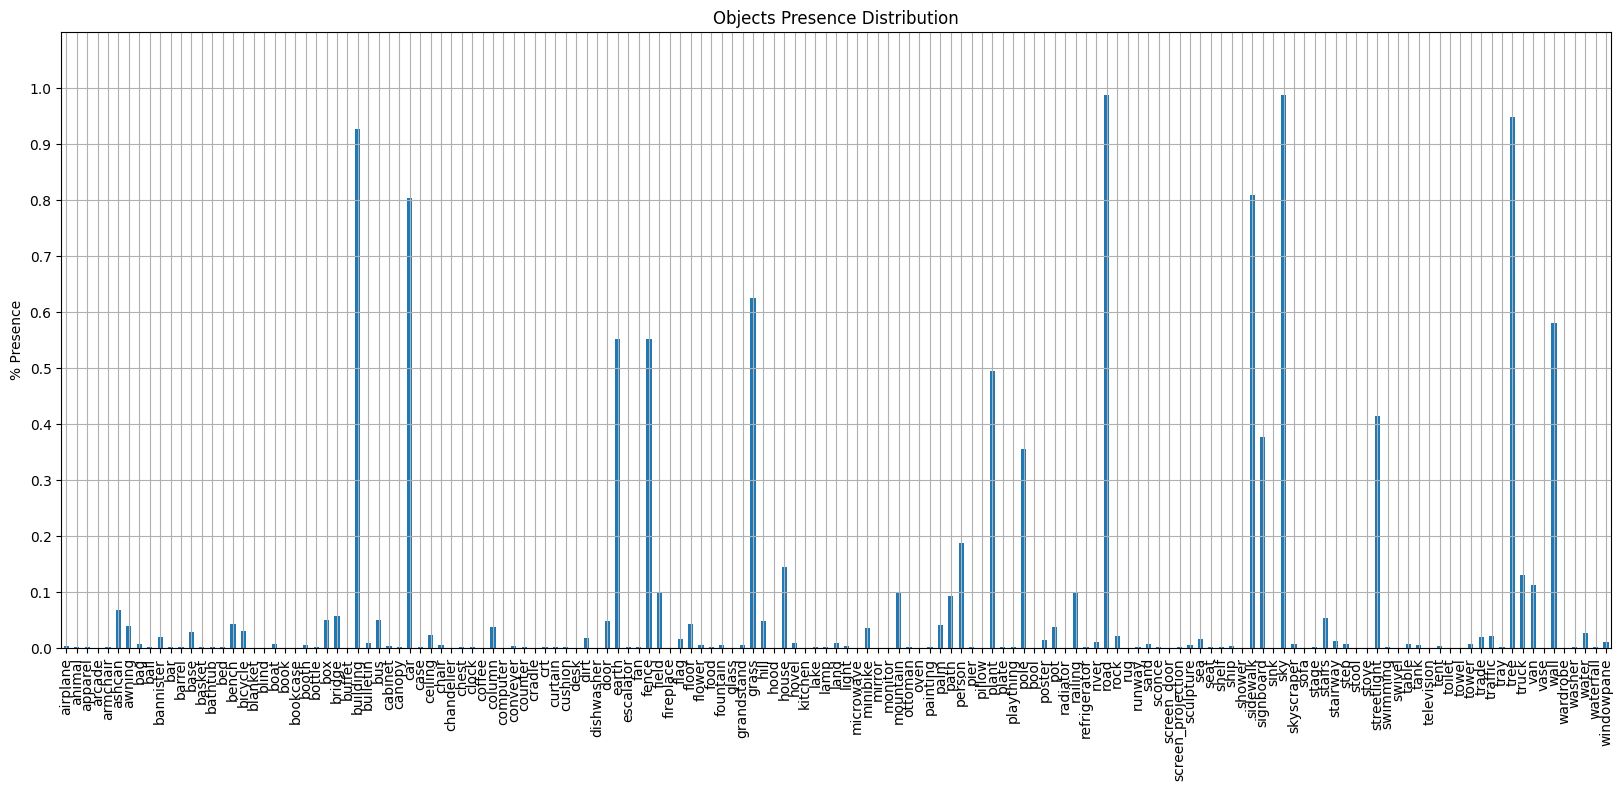

In [15]:
sum_df = features_df.sum()/len(data_df)

ax = sum_df.plot(kind="bar", figsize=(20,8), ylabel="% Presence", rot=90, ylim=(0.0,1.1), yticks=list(np.arange(0,1.1,0.10)))
plt.title(f"Objects Presence Distribution")
plt.grid(True)
plt.show()
# plt.savefig(f"{MAIN_OUT_PATH}objects_distribution.png", bbox_inches='tight', pad_inches = 0.5)
# plt.clf()
# plt.cla()
# plt.close()

In [16]:
keep_features_indices = sum_df[sum_df>0.1].index.values
len(keep_features_indices), keep_features_indices

(19,
 array(['building', 'car', 'earth', 'fence', 'grass', 'house', 'mountain',
        'person', 'plant', 'pole', 'road', 'sidewalk', 'signboard', 'sky',
        'streetlight', 'tree', 'truck', 'van', 'wall'], dtype=object))

In [17]:
normalized_features = (features_df[keep_features_indices] ).copy()
normalized_features

,building,car,earth,fence,grass,house,mountain,person,plant,pole,road,sidewalk,signboard,sky,streetlight,tree,truck,van,wall
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110983,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
110984,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
110985,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
110986,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [18]:
indeces = ["image_id"]
indeces.extend(keep_features_indices)
indeces.extend(["perception", "label", 'lat', 'long', 'City', 'Country', 'Continent', 'image_path'])

In [19]:
opf_df = data_df[indeces].copy()
# opf_df.iloc[:, 1:-4] = X_df[keep_features_indices].copy()
opf_df

,image_id,building,car,earth,fence,grass,house,mountain,person,plant,...,van,wall,perception,label,lat,long,City,Country,Continent,image_path
0,513cc058fdc9f0358700137e,4.187520,2.078247,12.711589,0.072734,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.831604,0.000000,2.520084,0,29.740200,-95.284784,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.740200_-...
1,513cc646fdc9f03587001930,0.015767,0.017293,6.755066,0.006104,4.382324,0.011698,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.333333,0,29.658276,-95.372664,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.658276_-...
2,513d35bffdc9f03587002b1e,4.181417,0.000000,0.000000,0.000000,18.264771,0.000000,0.000000,0.000000,0.073751,...,0.000000,0.000000,3.333333,0,29.660180,-95.370341,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.660180_-...
3,513cc072fdc9f0358700139b,1.689148,0.000000,0.211589,0.001017,4.818726,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.634921,1,29.660599,-95.370350,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.660599_-...
4,513cc0eafdc9f03587001413,0.000000,0.752258,0.000000,0.000000,5.619812,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.811105,1,29.661336,-95.385899,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.661336_-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110983,5140b899fdc9f04926001ca5,0.699870,0.000000,0.188700,0.000000,0.081889,0.000000,0.983683,0.000000,0.000000,...,0.000000,0.000000,4.373219,1,45.843234,16.046164,Zagreb,Croatia,Europe,data/PlacePulse_2//images//Zagreb/45.843234_16...
110984,5140b75efdc9f049260019a9,5.694580,12.957764,5.160014,0.000000,5.682373,1.736450,0.000000,0.000000,0.691223,...,0.000000,0.000000,3.333333,0,45.844200,16.033535,Zagreb,Croatia,Europe,data/PlacePulse_2//images//Zagreb/45.844200_16...
110985,5140b909fdc9f04926001d7d,9.884135,0.000000,0.034587,12.675476,5.847168,1.150004,0.000000,0.000000,5.815633,...,0.000000,0.348918,5.017316,1,45.844303,16.048495,Zagreb,Croatia,Europe,data/PlacePulse_2//images//Zagreb/45.844303_16...
110986,5140b8b6fdc9f04926001cdc,20.867920,0.000000,0.773112,12.282308,16.357931,0.000000,0.000000,0.010681,0.025940,...,0.000000,0.436910,5.211386,1,45.844791,16.047443,Zagreb,Croatia,Europe,data/PlacePulse_2//images//Zagreb/45.844791_16...


In [20]:
opf_df.iloc[:, 1:-8].sum()/len(opf_df)

building       13.553064
car             3.193109
earth           2.069011
fence           1.196193
grass           3.305462
house           0.264995
mountain        0.088227
person          0.071964
plant           1.105782
pole            0.193175
road           26.658191
sidewalk        2.829880
signboard       0.161306
sky            24.698304
streetlight     0.061694
tree           16.775541
truck           0.177820
van             0.124564
wall            1.735493
dtype: float64

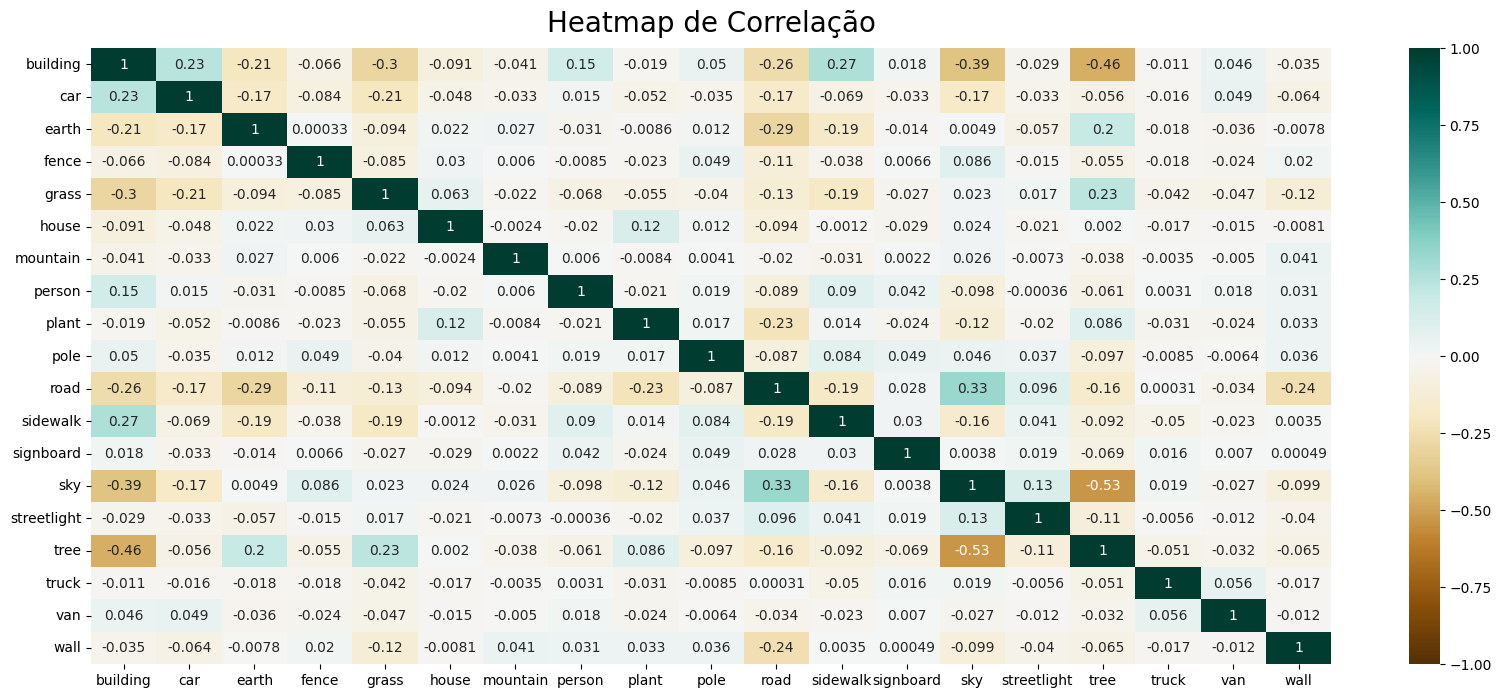

In [21]:
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(opf_df.iloc[:, 1:-8].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Heatmap de Correlação', fontdict={'fontsize':20}, pad=12);

### Creating data

To d3

In [34]:
to_map_df = opf_df[["lat", "long", "perception"]].copy()
to_map_df.rename(columns={"lat": "0", "long": "1", "perception": "score"}, inplace=True)
to_map_df

,0,1,score
0,29.740200,-95.284784,2.520084
1,29.658276,-95.372664,3.333333
2,29.660180,-95.370341,3.333333
3,29.660599,-95.370350,5.634921
4,29.661336,-95.385899,4.811105
...,...,...,...
110983,45.843234,16.046164,4.373219
110984,45.844200,16.033535,3.333333
110985,45.844303,16.048495,5.017316
110986,45.844791,16.047443,5.211386


In [36]:
to_map_df.to_csv(f"{MAIN_OUT_PATH}static/mapping.csv", sep="\\", index=False)

To analyze

In [28]:
city_df = opf_df[opf_df["Country"]=="USA"].copy()
city_df

,image_id,building,car,earth,fence,grass,house,mountain,person,plant,...,van,wall,perception,label,lat,long,City,Country,Continent,image_path
0,513cc058fdc9f0358700137e,4.187520,2.078247,12.711589,0.072734,0.000000,0.000000,0.0,0.000000,0.000000,...,0.831604,0.000000,2.520084,0,29.740200,-95.284784,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.740200_-...
1,513cc646fdc9f03587001930,0.015767,0.017293,6.755066,0.006104,4.382324,0.011698,0.0,0.000000,0.000000,...,0.000000,0.000000,3.333333,0,29.658276,-95.372664,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.658276_-...
2,513d35bffdc9f03587002b1e,4.181417,0.000000,0.000000,0.000000,18.264771,0.000000,0.0,0.000000,0.073751,...,0.000000,0.000000,3.333333,0,29.660180,-95.370341,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.660180_-...
3,513cc072fdc9f0358700139b,1.689148,0.000000,0.211589,0.001017,4.818726,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,5.634921,1,29.660599,-95.370350,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.660599_-...
4,513cc0eafdc9f03587001413,0.000000,0.752258,0.000000,0.000000,5.619812,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,4.811105,1,29.661336,-95.385899,Houston,USA,North America,data/PlacePulse_2//images//Houston/29.661336_-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109902,5140b987fdc9f04926001e81,1.538086,5.246480,5.097961,5.472310,5.952454,0.000000,0.0,0.000000,0.000000,...,0.000000,0.311279,4.111234,1,38.987782,-77.024975,Washington DC,USA,North America,data/PlacePulse_2//images//Washington DC/38.98...
109903,5140b9c2fdc9f04926001efb,0.562541,6.016032,1.997375,0.000000,4.396057,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,7.329425,2,38.990176,-77.033811,Washington DC,USA,North America,data/PlacePulse_2//images//Washington DC/38.99...
109904,5140b6b6fdc9f049260017d1,23.600769,1.194763,0.008138,0.000000,0.180562,0.000000,0.0,0.000000,0.000000,...,0.000000,2.150472,4.608201,1,38.992450,-77.029290,Washington DC,USA,North America,data/PlacePulse_2//images//Washington DC/38.99...
109905,5140b6f2fdc9f04926001876,16.897583,1.406352,0.000000,0.000000,0.653076,0.000000,0.0,0.016785,0.000000,...,0.225321,0.000000,4.929774,1,38.993038,-77.031768,Washington DC,USA,North America,data/PlacePulse_2//images//Washington DC/38.99...


In [29]:
data_dict = {
    "id": city_df["image_id"].values.tolist(),
    "features": city_df.iloc[:, 1:-8].values.tolist(),
    "features_name": city_df.columns[1:-8].values.tolist(),
    "safety": city_df["perception"].values.tolist(),
    "label": city_df["label"].values.tolist(),
    "latitude": city_df["lat"].values.tolist(),
    "longitude": city_df["long"].values.tolist(),
    "city": city_df["City"].values.tolist(),
    "country": city_df["Country"].values.tolist(),
    "continent": city_df["Continent"].values.tolist(),
    "path": city_df["image_path"].values.tolist(),
}

In [30]:
joblib.dump(data_dict, f"{MAIN_OUT_PATH}/static/data.joblib")

['outputs//static/data.joblib']

To train

In [25]:
data_dict = {
    "id": opf_df["image_id"].values.tolist(),
    "features": opf_df.iloc[:, 1:-8].values.tolist(),
    "features_name": opf_df.columns[1:-8].values.tolist(),
    "safety": opf_df["perception"].values.tolist(),
    "label": opf_df["label"].values.tolist(),
    "latitude": opf_df["lat"].values.tolist(),
    "longitude": opf_df["long"].values.tolist(),
    "city": opf_df["City"].values.tolist(),
    "country": opf_df["Country"].values.tolist(),
    "continent": opf_df["Continent"].values.tolist(),
    "path": opf_df["image_path"].values.tolist(),
}

In [26]:
# data_dict["images"] = []
# for index, row in tqdm(opf_df.iterrows()):
#     np_image = np.array(Image.open(row["image_path"]))
#     image_reshape = np.moveaxis(np_image, -1, 0)
#     data_dict["images"].append(image_reshape)

#     #features = row[ 1:-4].copy().to_list()
#     #data_dict["features"].append(features)
    
#     #data_dict["id"].append(row["image_file_name"])
#     #data_dict["safety"].append(row["safety"])
#     #data_dict["label"].append(row["label"])
#     #data_dict["path"].append(row["image_path"])


In [27]:
joblib.dump(data_dict, f"{MAIN_OUT_PATH}/static/data_train.joblib")

['outputs//static/data_train.joblib']